***
# **Small-MOCCA: Dataset exploration**

***
Exploration of a subset of the MOCCA Survey Dataset I. Creation of a regressión dataset for $M_{\text MMO}$ estimation. 

> **Status:** Load of information available and operating.
***

In [2]:
# Change to working directory -----------------------------------------------------------------------------------#
os.chdir("../")
#----------------------------------------------------------------------------------------------------------------#

In [1]:
# Libraries -----------------------------------------------------------------------------------------------------#
import os

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
#----------------------------------------------------------------------------------------------------------------#

In [ ]:
# Custome functions ---------------------------------------------------------------------------------------------#
from src.utils.directory         import list_all_directories, load_mocca_survey_imbh_history
from src.utils.phyfactors        import relaxation_time, collision_time, core_collapse_time, critical_mass
from src.utils.vizualize         import corr_plot
from src.processing.format       import target_preparation, time_preparation
from src.processing.moccasurvey  import mocca_survey_dataset
#----------------------------------------------------------------------------------------------------------------#

In [ ]:
# Load name files and directories -------------------------------------------------------------------------------#
sim_files_path = "./rawdata/moccasurvey/sims/"
simulations    = list_all_directories(sim_files_path)

# Verbose
print(f"MOCCA Models available for analysis: {len(simulations)}")
#----------------------------------------------------------------------------------------------------------------#

MOCCA Models available for analysis: 455


In [ ]:
# Load simulation info ------------------------------------------------------------------------------------------#
imbh_history, system = load_mocca__survey_imbh_history(file_path = f"{simulations[27]}/",
                                                    init_conds_sim  = True,
                                                    col_description = True,
                                                    stellar_map     = True,
                                                    init_conds_evo  = True)

# Getting imbh history df, initial_conditions, column definitions, and stellar type mappig
imbh_df           = imbh_history[0]
imbh_init_conds   = imbh_history[1]
imbh_col_dict     = imbh_history[2]
imbh_stellar_dict = imbh_history[3]

# Retrive temporal evolution df of initial conditions and their column descriptions
system_df       = system[0]
system_col_dict = system[1]

#----------------------------------------------------------------------------------------------------------------#

In [6]:
# Columns of interest and details of the system df ....----------------------------------------------------------#
int_cols = ["17", "3", "23", "46", "44", "28", "2"]

print(110*"_")
print("Columns of interest in the system dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {system_col_dict[n_col]['column']}")
    print(f"Column description : {system_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the system dataframe")
print(f"Number of rows         : {len(system_df)}")
print(f"Maximun evolution time : {system_df['tphys'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the system dataframe
______________________________________________________________________________________________________________
Column number      : 17
Column name        : r_h
Column description : actual half-mas radius in pc
______________________________________________________________________________________________________________
Column number      : 3
Column name        : smt
Column description : total mass in Msun
______________________________________________________________________________________________________________
Column number      : 23
Column name        : vc
Column description : central velocity dispersion in km/s (mass weighted)
______________________________________________________________________________________________________________
Column number      : 46
Column name        : nt
Column description : actual number of objects

In [7]:
# Columns of interest and details of the history df ....---------------------------------------------------------#
int_cols = ["4", "10"]

print(110*"_")
print("Columns of interest in the imbh history dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {imbh_col_dict[n_col]['column']}")
    print(f"Column description : {imbh_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the imbh history dataframe")
print(f"Number of rows         : {len(imbh_df)}")
print(f"Maximun evolution time : {imbh_df['time[Myr]'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the imbh history dataframe
______________________________________________________________________________________________________________
Column number      : 4
Column name        : time
Column description : Time of the event in Myr
______________________________________________________________________________________________________________
Column number      : 10
Column name        : massNew
Column description : Mass of the primary after the event [Msun]
______________________________________________________________________________________________________________
Details of interest in the imbh history dataframe
Number of rows         : 15350
Maximun evolution time : 14999.267
______________________________________________________________________________________________________________


In [ ]:
# Extract the example of initial conditions ---------------------------------------------------------------------#
rh      = system_df["r_h"][0]
v_disp  = system_df["vc"][0]
m_tot   = system_df["smt"][0]
n       = system_df["nt"][0]
m_mean  = system_df["atot"][0]
m_max   = system_df["smsm"][0]
tau     = imbh_df["time[Myr]"].max() - imbh_df["time[Myr]"].min()

print(100*"_")
print("Initial conditions for the selected simulation:")
print(100*"_")
print(f"  Half-mass radius (r_h)       : {rh:.3f} pc")
print(f"  Velocity dispersion (v_disp) : {v_disp:.3f} km/s")
print(f"  Total mass (m_tot)           : {m_tot:.3e} Msun")
print(f"  Number of stars (n)          : {n}")
print(f"  Mean stellar mass (m_mean)   : {m_mean:.3f} Msun")
print(f"  Maximum stellar mass (m_max) : {m_max:.3f} Msun")
print(f"  Cluster evolution time (tau) : {tau:.3f} Myr")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Initial conditions for the selected simulation:
____________________________________________________________________________________________________
  Half-mass radius (r_h)       : 0.599 pc
  Velocity dispersion (v_disp) : 31.963 km/s
  Total mass (m_tot)           : 4.242e+05 Msun
  Number of stars (n)          : 700000
  Mean stellar mass (m_mean)   : 0.606 Msun
  Maximum stellar mass (m_max) : 99.719 Msun
  Cluster evolution time (tau) : 14999.267 Myr
____________________________________________________________________________________________________


In [ ]:
# Compute an example of the relevant physical quantities --------------------------------------------------------#
t_relax = relaxation_time(n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)
t_coll  = collision_time(hm_radius=rh, n_stars=n, mass_per_star=m_mean, v_disp=v_disp, stellar_radius=1.0)
t_cc    = core_collapse_time(m_mean=m_mean, m_max=m_max, n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)  
M_crit  = critical_mass(hm_radius=rh, mass_per_star=m_mean, cluster_age=tau, v_disp=v_disp, stellar_radius=1.0)

print(100*"_")
print("Physical timescales and quantities:")
print(100*"_")
print(f"  Relaxation time (t_relax) : {t_relax:.3f} ")
print(f"  Collision time (t_coll))  : {t_coll:.3f} ")
print(f"  Core collapse time (t_cc) : {t_cc:.3f} ")
print(f"  Critical mass  (M_crit)   : {M_crit:3e} ")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Physical timescales and quantities:
____________________________________________________________________________________________________
  Relaxation time (t_relax) : 95.356 Myr 
  Collision time (t_coll))  : 94932.443 Myr 
  Core collapse time (t_cc) : 1.912 Myr 
  Critical mass  (M_crit)   : 6.354095e+05 solMass 
____________________________________________________________________________________________________


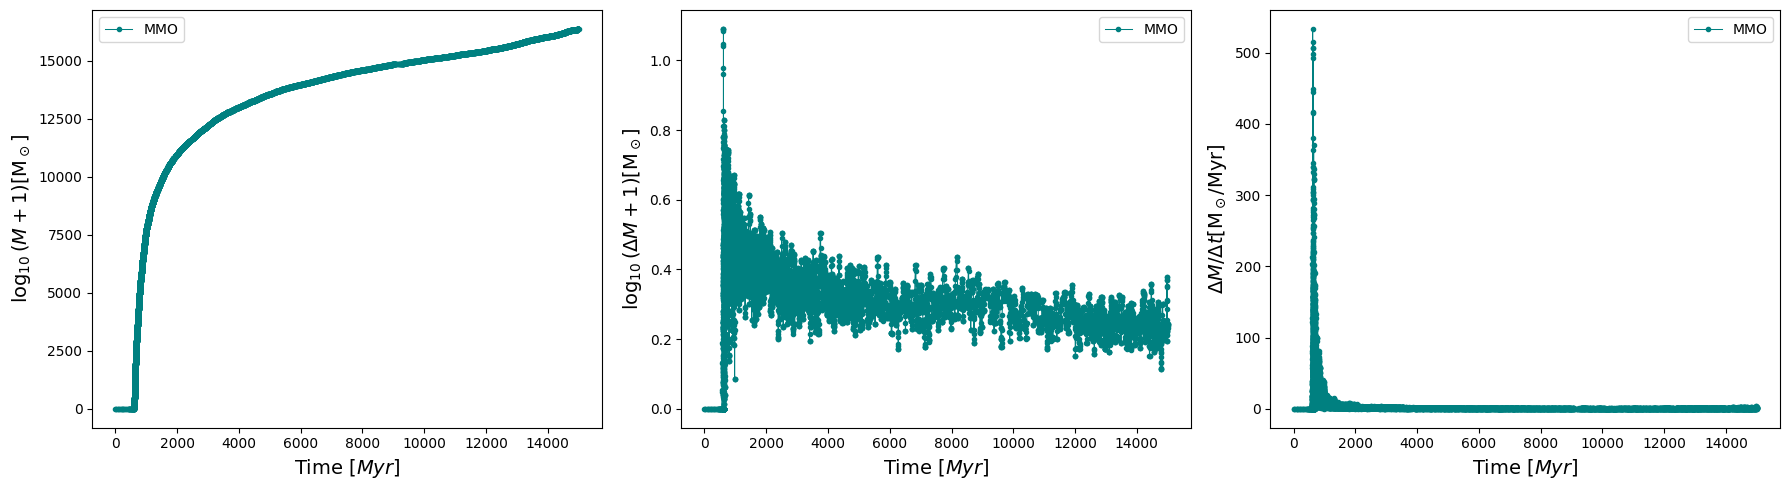

In [10]:
example_df = imbh_df.drop_duplicates(subset="time[Myr]")

# Get random indices for 80% of the data
n_samples      = int(len(example_df) * 0.8)
random_indices = example_df.sample(n=n_samples, random_state=42).index

# Select those rows and sort by time
sample_df = example_df.loc[random_indices].sort_values('time[Myr]')

fig, ax  = plt.subplots(1, 3, figsize=(18, 5))

# retrieve temporal values
m_evol    = target_preparation(mass_evolution  = sample_df["massNew[Msun](10)"],
                                time_evolution = sample_df["time[Myr]"], 
                                norm_factor    = None,
                                target_type    = "M",
                                log10_scale    = False)

time_evol = time_preparation(time_evolution = sample_df["time[Myr]"],
                             norm_factor    = None)

# First subplot: IMBH mass
ax[0].plot(time_evol, m_evol, lw=0.75, label='MMO', color="teal", marker=".") 
ax[0].set_ylabel(r'$\log_{10}(M+1)[\rm M_\odot]$', size=14)
ax[0].set_xlabel('Time $[Myr]$', size=14)
ax[0].legend()

# retrieve temporal values
dm_evol   = target_preparation(mass_evolution  = sample_df["massNew[Msun](10)"],
                                time_evolution = sample_df["time[Myr]"], 
                                norm_factor    = None,
                                target_type    = "dM",
                                log10_scale    = True)
time_evol = time_preparation(time_evolution = sample_df["time[Myr]"],
                             norm_factor    = None)


# Second subplot: IMBH mass change
ax[1].plot(time_evol, dm_evol, lw=0.75, label='MMO', color="teal", marker=".") 
ax[1].set_ylabel(r'$\log_{10}(\Delta M+1)[\rm M_\odot]$', size=14)
ax[1].set_xlabel('Time $[Myr]$', size=14)
ax[1].legend()

# retrieve temporal values
dmdt_evol = target_preparation(mass_evolution  = sample_df["massNew[Msun](10)"],
                                time_evolution = sample_df["time[Myr]"], 
                                norm_factor    = None,
                                target_type    = "dM/dt")
time_evol = time_preparation(time_evolution = sample_df["time[Myr]"],
                             norm_factor    = None)


# Third subplot: IMBH mass rate
ax[2].plot(time_evol, dmdt_evol, lw=0.75, label='MMO', color="teal", marker=".") 
ax[2].set_ylabel(r'$\Delta M /\Delta t[\rm M_\odot/Myr]$', size=14)
ax[2].set_xlabel('Time $[Myr]$', size=14)
ax[2].legend()

plt.tight_layout()
plt.savefig("sim_preprocess.jpg")
plt.show()

In [11]:
# Convert to numpy array for easy indexing
simulations = np.array(simulations)
n_total     = len(simulations)

# Shuffle indices
shuffled_indices = np.random.permutation(n_total)

# Compute split sizes
n_train = int(n_total * 0.7)
n_val   = int(n_total * 0.2)
n_test  = n_total - n_train - n_val  # ensures all elements are used

# Partition indices
train_idx = shuffled_indices[:n_train]
val_idx   = shuffled_indices[n_train:n_train + n_val]
test_idx  = shuffled_indices[n_train + n_val:]

# Partition lists
train_simulations = simulations[train_idx].tolist()
val_simulations   = simulations[val_idx].tolist()
test_simulations  = simulations[test_idx].tolist()

print(110*"_")
print("Numero total de simulaciones por particion")
print(110*"_")
print(f"Train: {len(train_simulations)}")
print(f"Val  : {len(val_simulations)}")
print(f"Test : {len(test_simulations)}")
print(110*"_")

______________________________________________________________________________________________________________
Numero total de simulaciones por particion
______________________________________________________________________________________________________________
Train: 318
Val  : 91
Test : 46
______________________________________________________________________________________________________________


In [12]:
# Obtencion de las particiones
train_points = mocca_dataset(simulations_path = train_simulations,
                             experiment_type  = "mass")
"""
val_points   = mocca_dataset(simulations_path = val_simulations,
                             experiment_type  = "mass")
"""                             
test_points  = mocca_dataset(simulations_path = test_simulations,
                             experiment_type  = "mass")

(-0.5, 7.5)

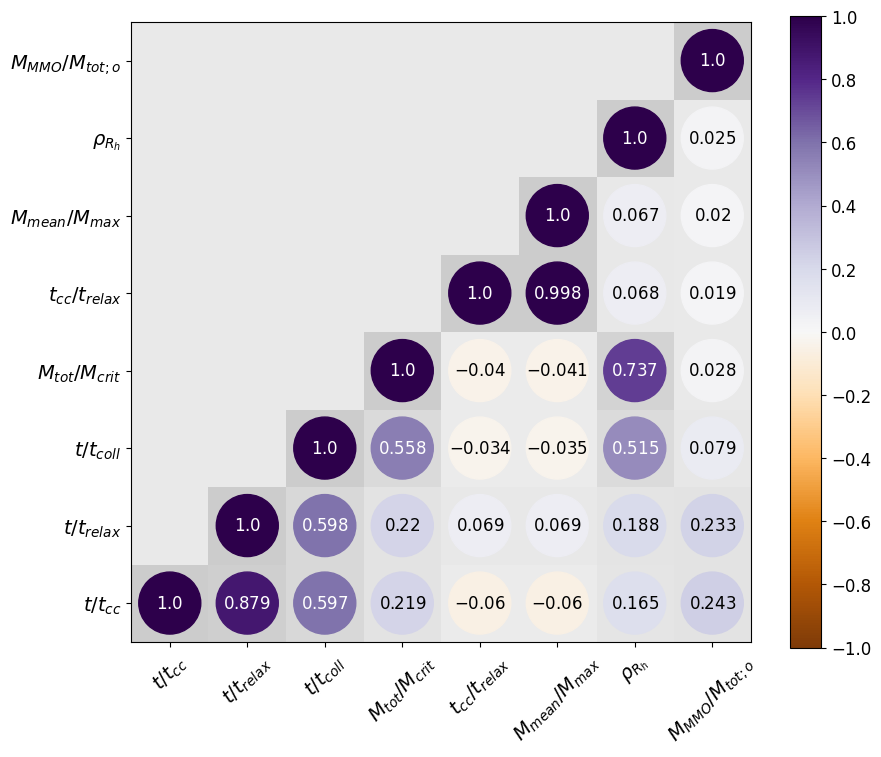

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 1. Create DataFrame from train_points and train_targets
feature_names = ["$t/t_{cc}$", "$t/t_{relax}$", "$t/t_{coll}$", 
                 "$M_{tot}/M_{crit}$", "$t_{cc}/t_{relax}$", "$M_{mean}/M_{max}$", r"$\rho_{R_h}$"]

df = pd.DataFrame(train_points[0], columns=feature_names)

df["$M_{MMO}/M_{tot;o}$"] = train_points[1]

# 2. Compute correlation matrix
correlation_matrix = df.corr(method="kendall")
axis = correlation_matrix.columns


# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(10, 10))

# Visualiza la matriz de correlación
correlation_matrix_array = correlation_matrix.to_numpy()

# Elimina los valores duplicados (debajo de la diagonal)
correlation_matrix_array = np.triu(correlation_matrix_array)

# Configura el cmap
cmap = plt.get_cmap('PuOr')  # Puedes cambiar 'viridis' por el cmap que desees
norm = Normalize(vmin=-1.0, vmax=1.0)

# Agrega los círculos con radio y color correspondiente a los valores de correlación
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        value = round(correlation_matrix_array[i, j], 3)
        if value != 0:  # Para evitar círculos en los valores 0
            color  = cmap(norm(value))
            radius = 0.4
            
            circle = plt.Circle((j, i), radius=radius, color=color, fill=True)
            ax.add_patch(circle)
            ax.text(j, i, f"${str(value)}$", ha='center', va='center', color='white' if value > 0.3 else 'black', fontsize=12)


# Configura la barra de color personalizada
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Necesario para que la barra de color muestre correctamente los valores

# Agrega la barra de color
cbar = plt.colorbar(sm, ax=ax, shrink=0.82, ticks=np.arange(-1, 1.1, 0.2))
cbar.ax.tick_params(labelsize=12)

# Configura las etiquetas y títulos
plt.xticks(range(len(correlation_matrix)), axis, rotation=45, size=14)
plt.yticks(range(len(correlation_matrix)), axis, size=14)

# Configura el color de la imagen para que sea más claro
ax.imshow(correlation_matrix_array, cmap='Greys', alpha=0.2, vmin=-1.0, vmax=1.0)

# Ajusta el límite para mostrar completamente los círculos en la diagonal
ax.set_xlim([-0.5, len(correlation_matrix) - 0.5])
ax.set_ylim([-0.5, len(correlation_matrix) - 0.5])


# Guarda la figura
#plt.savefig("./figures/general_plots/Multiple-Sims/Correlograms/spearman/spearman_corr_matrix_nodim.jpg", bbox_inches="tight", dpi=900)

In [13]:
# Proof of concepts
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

/home/jsaavedra/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [41]:
x_train, y_train = train_points[0], train_points[1]
x_test, y_test = test_points[0], test_points[1]

print(y_train.min(), y_test.min())

# Model
model = xgb.XGBRegressor(n_estimators  = 1500,
                         max_depth     = 4,
                         learning_rate = 0.01,
                         objective     = "reg:squarederror",
                         random_state  = 42)

# Train
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(x_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.4f}")
print(f"Test R2  : {r2:.4f}")

0.0 0.0
Test MSE : 0.0001
Test R2  : 0.3280


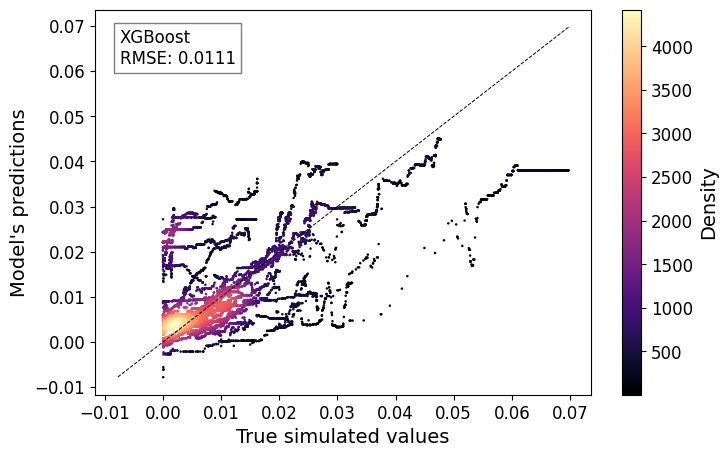

In [43]:
corr_plot(predictions=y_pred, true_values=y_test, path_save="./", name_file="proof_of_concepts", model_name="XGBoost")


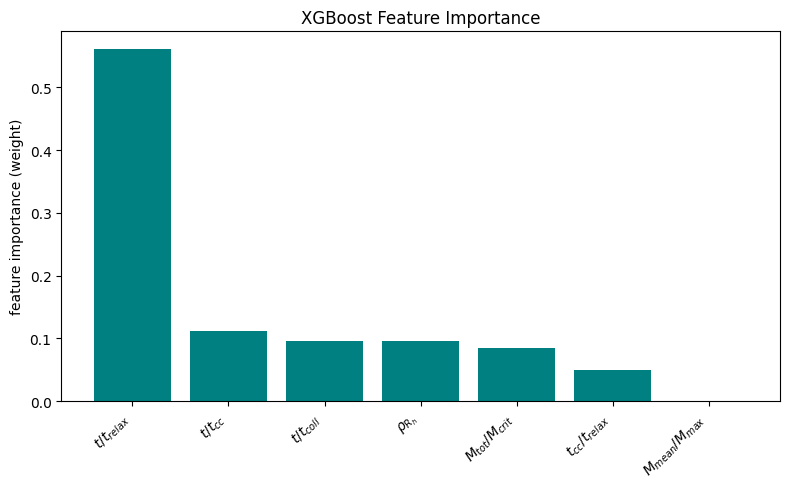

In [45]:
# Get feature importances (e.g., by gain)
importances = model.feature_importances_
feature_names = ["$t/t_{cc}$", "$t/t_{relax}$", "$t/t_{coll}$", 
                 "$M_{tot}/M_{crit}$", "$t_{cc}/t_{relax}$", "$M_{mean}/M_{max}$", r"$\rho_{R_h}$"]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices], align='center', color="teal")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel('feature importance (weight)')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()